In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.impute import SimpleImputer

In [21]:
historical_weather = pd.read_csv(r"C:\0A___________________________________\Predictor 1.0\historical_weather.csv")
test_data = pd.read_csv(r"C:\0A___________________________________\Predictor 1.0\submission_key.csv")

In [22]:
historical_weather.drop(columns=['snow_depth_mm'], inplace=True)

In [23]:
historical_weather['date'] = pd.to_datetime(historical_weather['date'])
test_data['date'] = pd.to_datetime(test_data['date'])

In [24]:
historical_weather['city_id'] = historical_weather['city_id'].str.extract('(\d+)').astype(int)
test_data['city_id'] = test_data['city_id'].str.extract('(\d+)').astype(int)

In [25]:
imputer = SimpleImputer(strategy='mean')

In [26]:
historical_weather[['avg_temp_c', 'min_temp_c', 'max_temp_c', 'precipitation_mm','avg_wind_dir_deg', 'avg_wind_speed_kmh']] = imputer.fit_transform(historical_weather[['avg_temp_c', 'min_temp_c', 'max_temp_c', 'precipitation_mm','avg_wind_dir_deg', 'avg_wind_speed_kmh']])

In [27]:
scaler = StandardScaler()
scaler = scaler.fit(historical_weather[['avg_temp_c', 'min_temp_c', 'max_temp_c', 'precipitation_mm','avg_wind_dir_deg', 'avg_wind_speed_kmh']])
historical_weather_scaled = scaler.transform(historical_weather[['avg_temp_c', 'min_temp_c', 'max_temp_c', 'precipitation_mm','avg_wind_dir_deg', 'avg_wind_speed_kmh']])

In [28]:
def prepare_data_for_lstm(data, n_past=14, n_future=7):
    X, Y = [], []
    for i in range(n_past, len(data) - n_future + 1):
        X.append(data[i - n_past:i, :])  # past days data
        Y.append(data[i:i + n_future, 0])  # future days target (avg_temp_c)
    return np.array(X), np.array(Y)

trainX, trainY = prepare_data_for_lstm(historical_weather_scaled)

In [29]:
# Define the LSTM model
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))  # Output layer for predicting avg_temp_c

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 14, 64)            18176     
                                                                 
 lstm_5 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 7)                 231       
                                                                 
Total params: 30,823
Trainable params: 30,823
Non-trainable params: 0
_________________________________________________________________


In [30]:
history = model.fit(trainX, trainY, epochs=10, batch_size=16, validation_split=0.1, verbose=1)

Epoch 1/10
10256/10256 [==============================] - 52s 5ms/step - loss: 0.1096 - val_loss: 0.0853
Epoch 2/10
10256/10256 [==============================] - 52s 5ms/step - loss: 0.0972 - val_loss: 0.0823
Epoch 3/10
10256/10256 [==============================] - 50s 5ms/step - loss: 0.0953 - val_loss: 0.0849
Epoch 4/10
10256/10256 [==============================] - 50s 5ms/step - loss: 0.0947 - val_loss: 0.0835
Epoch 5/10
10256/10256 [==============================] - 49s 5ms/step - loss: 0.0935 - val_loss: 0.0845
Epoch 6/10
10256/10256 [==============================] - 50s 5ms/step - loss: 0.0926 - val_loss: 0.0824
Epoch 7/10
10256/10256 [==============================] - 49s 5ms/step - loss: 0.0916 - val_loss: 0.0827
Epoch 8/10
10256/10256 [==============================] - 50s 5ms/step - loss: 0.0909 - val_loss: 0.0834
Epoch 9/10
10256/10256 [==============================] - 51s 5ms/step - loss: 0.0901 - val_loss: 0.0828
Epoch 10/10
10256/10256 [==============================

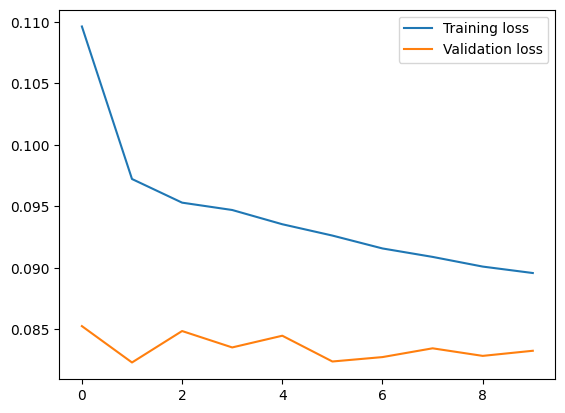

In [31]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [37]:
predictions = []
for index, row in test_data.iterrows():
    city_id = row['city_id']
    date = row['date']
    city_data = historical_weather[(historical_weather['city_id'] == city_id) & (historical_weather['date'] <= date)]
    city_data_scaled = scaler.transform(city_data[['avg_temp_c', 'min_temp_c', 'max_temp_c', 'precipitation_mm','avg_wind_dir_deg', 'avg_wind_speed_kmh']])
    
    # Reshape data for LSTM input
    X = np.expand_dims(city_data_scaled[-14:, :], axis=0)  # Using last 14 days data
    prediction = model.predict(X)
    predictions.append(prediction[0][0])  # Predicted avg_temp_c for the date

# Create submission dataframe
submission = pd.DataFrame({
    'submission_ID': test_data['submission_ID'],
    'avg_temp_c': predictions
})

# Save submission to CSV file
submission.to_csv('my_submission.csv', index=False)

1/1 [==============================] - 0s 17ms/step
